In [1]:
import capnp
import codecs
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import statistics
from scoredevelopment import visualizeScoreDevelopment

capnp.remove_import_hook()
interface_capnp = capnp.load("../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

kj/filesystem-disk-unix.c++:1690: warning: PWD environment variable doesn't match current directory; pwd = /vscode/vscode-server/bin/linux-x64/97dec172d3256f8ca4bfb2143f3f76b503ca0534


In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

# Overlapping value predictions

## Generate event log

In [3]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < overlappingRulesModel.json > /tmp/overlappingRulesModel.bin
with open("/tmp/overlappingRulesModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light = red THEN num = 42.000000
IF light = red THEN num = 13.000000



In [4]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [5]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "num",\n  valueRule = (constant =...        520
1  ( variable = "num",\n  valueRule = (constant =...        460

## Look at the data

Mode of the distribution: 42.0


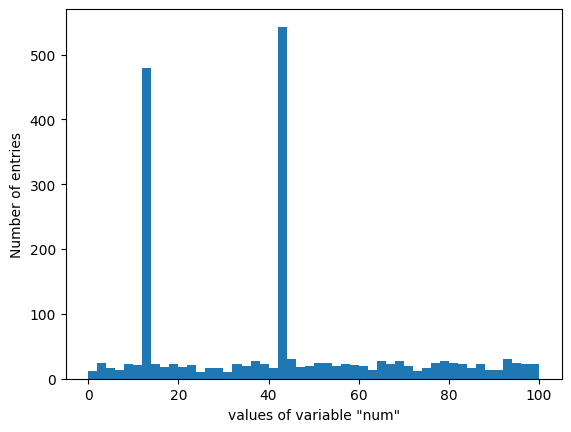

In [6]:
from visualdistribution import visualizeVariableDistribution
visualizeVariableDistribution(resolvedEventLogPromise.log, "num")
plt.show()

## Score development

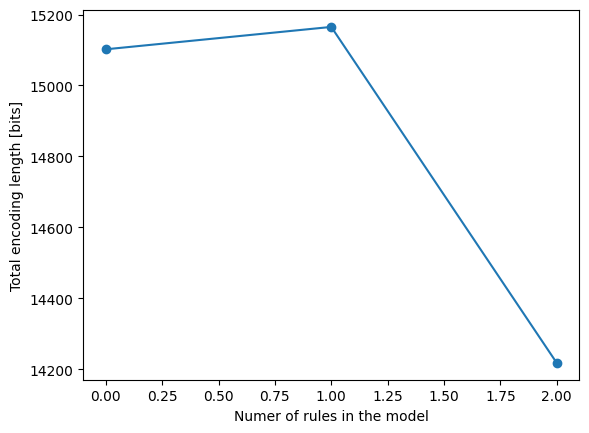

In [7]:
visualizeScoreDevelopment("overlappingRulesModel", resolvedEventLogPromise.log, interface_capnp)

Here, with overlapping rules, the encoding length increases slightly for one rule, since it causes a lot of mismatches each time the respective other value occurs in the event log. However, the true generating model saves quite a lot of bits as it should.

# Overlapping change predictions

## Generate event log

In [8]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < overlappingChangeRulesModel.json > /tmp/overlappingChangeRulesModel.bin
with open("/tmp/overlappingChangeRulesModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light = red THEN num = num_prev * 1.300000
IF light = red THEN num = num_prev - 8.000000



In [9]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [10]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "num",\n  factorRule = (constant ...        493
1  ( variable = "num",\n  differenceRule = (const...        433

## Look at the data

Mode of the distribution: 89.80000000000001


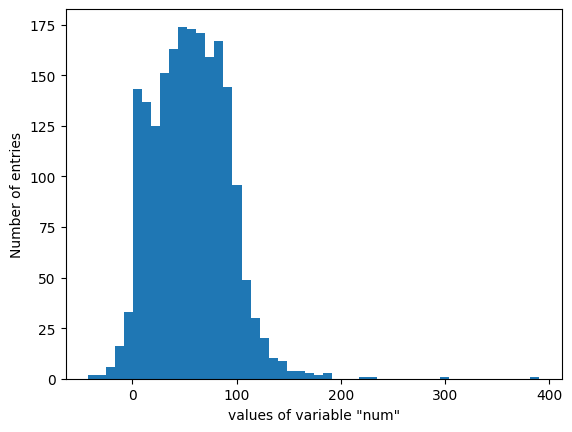

In [11]:
from visualdistribution import visualizeVariableDistribution
visualizeVariableDistribution(resolvedEventLogPromise.log, "num")
plt.show()

## Score development

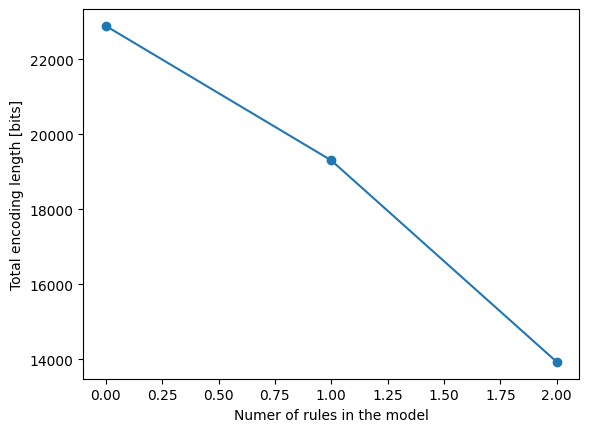

In [12]:
visualizeScoreDevelopment("overlappingChangeRulesModel", resolvedEventLogPromise.log, interface_capnp)

Here, with overlapping rules on the change of a variable, there is a gradual decrease of the encoding length. In contrast to the first example this happens since the values predicted by the rules are not already cheap to encode according to the global distribution.

# Many overlapping rules

## Generate event log

In [13]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < manyOverlappingRulesModel.json > /tmp/manyOverlappingRulesModel.bin
with open("/tmp/manyOverlappingRulesModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light1 = red THEN num = 42.000000
IF light2 = red THEN num = num_prev - 10.000000
IF light1 = green THEN num = num_prev * 0.500000
IF light2 = yellow THEN num IN [75.000000, 85.000000]



In [14]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [15]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "num",\n  differenceRule = (const...        421
1  ( variable = "num",\n  valueRangeRule = (min =...        425
2  ( variable = "num",\n  factorRule = (constant ...        421
3  ( variable = "num",\n  valueRule = (constant =...        467

## Look at the data

Mode of the distribution: 42.0


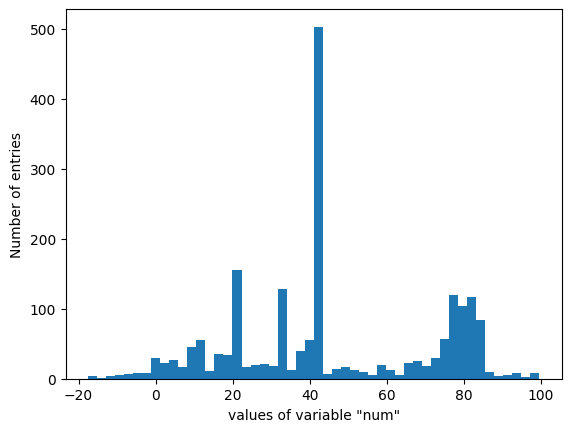

In [16]:
from visualdistribution import visualizeVariableDistribution
visualizeVariableDistribution(resolvedEventLogPromise.log, "num")
plt.show()

## Score development

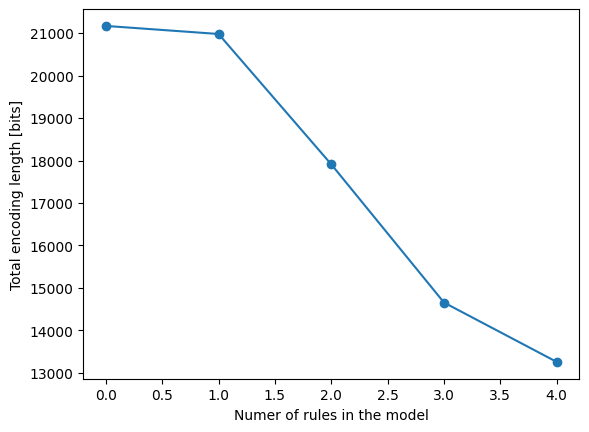

In [17]:
visualizeScoreDevelopment("manyOverlappingRulesModel", resolvedEventLogPromise.log, interface_capnp)

With more overlapping rules, the general behavior of the code length is similar to the change rule case.

# Specializing rules

## Generate event log

In [18]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < specializingOverlappingRulesModel.json > /tmp/specializingOverlappingRulesModel.bin
with open("/tmp/specializingOverlappingRulesModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light1 = red THEN num = num_prev - 4.000000
IF (light2 = red) AND (light1 = red) THEN num = num_prev - 10.000000



In [19]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [20]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "num",\n  differenceRule = (const...        111
1  ( variable = "num",\n  differenceRule = (const...        531

## Look at the data

Mode of the distribution: 6.300000000000001


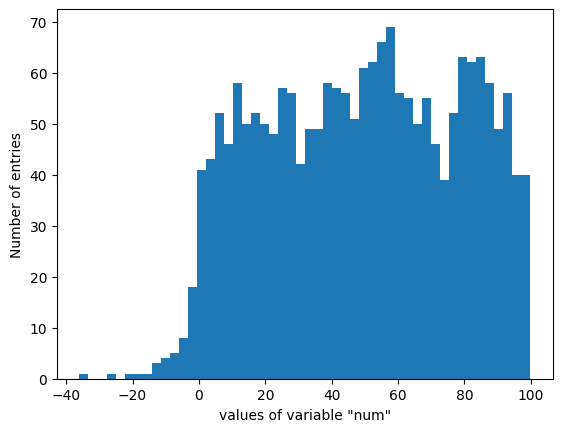

In [21]:
from visualdistribution import visualizeVariableDistribution
visualizeVariableDistribution(resolvedEventLogPromise.log, "num")
plt.show()

## Score development

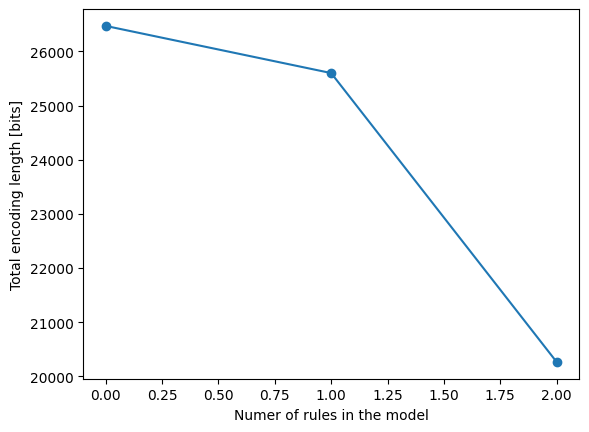

In [22]:
visualizeScoreDevelopment("specializingOverlappingRulesModel", resolvedEventLogPromise.log, interface_capnp)

Overlapping rules due to a specialization seem to save bits in the encoding.

# Fragmentation of overlapping rules

## Fragmentation in the update rule

In [3]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < updateRuleFragmentationOverlappingModel.json > /tmp/updateRuleFragmentationOverlappingModel.bin
with open("/tmp/updateRuleFragmentationOverlappingModel.bin", "rb") as file:
    overlappingModel = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(overlappingModel).wait().string)

IF light1 = red THEN num IN [20.000000, 50.000000]
IF light2 = red THEN num IN [40.000000, 70.000000]



In [4]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < updateRuleFragmentationFragmentedModel.json > /tmp/updateRuleFragmentationFragmentedModel.bin
with open("/tmp/updateRuleFragmentationFragmentedModel.bin", "rb") as file:
    fragmentedModel = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(fragmentedModel).wait().string)

IF light1 = red THEN num IN [20.000000, 39.900000]
IF light2 = red THEN num IN [50.100000, 70.000000]
IF (light2 = red) AND (light1 = red) THEN num IN [40.000000, 50.000000]



In [5]:
eventLogPromise = processDataUpdates.generateEventLog(model=overlappingModel, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [6]:
processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=overlappingModel).wait().result

22387.45393507717

In [7]:
processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=fragmentedModel).wait().result

23179.393385806936

Non-fragmented (true) model has fewer bits. :)

## Fragmentation in the condition

In [8]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < conditionFragmentationOverlappingModel.json > /tmp/conditionFragmentationOverlappingModel.bin
with open("/tmp/conditionFragmentationOverlappingModel.bin", "rb") as file:
    overlappingModel = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(overlappingModel).wait().string)

IF (num <= 50.000000) AND (20.000000 <= num) THEN light IN {red}
IF (num <= 70.000000) AND (40.000000 <= num) THEN light IN {green}



In [9]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < conditionFragmentationFragmentedModel.json > /tmp/conditionFragmentationFragmentedModel.bin
with open("/tmp/conditionFragmentationFragmentedModel.bin", "rb") as file:
    fragmentedModel = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(fragmentedModel).wait().string)

IF (num <= 39.900000) AND (20.000000 <= num) THEN light IN {red}
IF (num <= 70.000000) AND (50.100000 <= num) THEN light IN {green}
IF (num <= 50.000000) AND (40.000000 <= num) THEN light IN {green, red}



In [10]:
eventLogPromise = processDataUpdates.generateEventLog(model=overlappingModel, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [11]:
processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=overlappingModel).wait().result

22098.08073469176

In [12]:
processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=fragmentedModel).wait().result

22207.5132679631

Non-fragmented (true) model has fewer bits. :)